In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from compound import (
    get_compound_return, 
    simulate_compound_return,
    build_dataframe,
    MONTHS_IN_YEAR,
    DEFAULT_RETIREMENT_YEARS,
    define_scenario
)

### Case of time evolution of loan and rental earnings

Total contribution to loans -127231.12559139018
Earnings through loan investment 617038.9198749395
Earnings through house renting 648000
Loan earnings per contribution -4.849748180776095

Years to reach loan and rental earnings equality 18
Years to reach loan and rental accumulated earnings equality 0


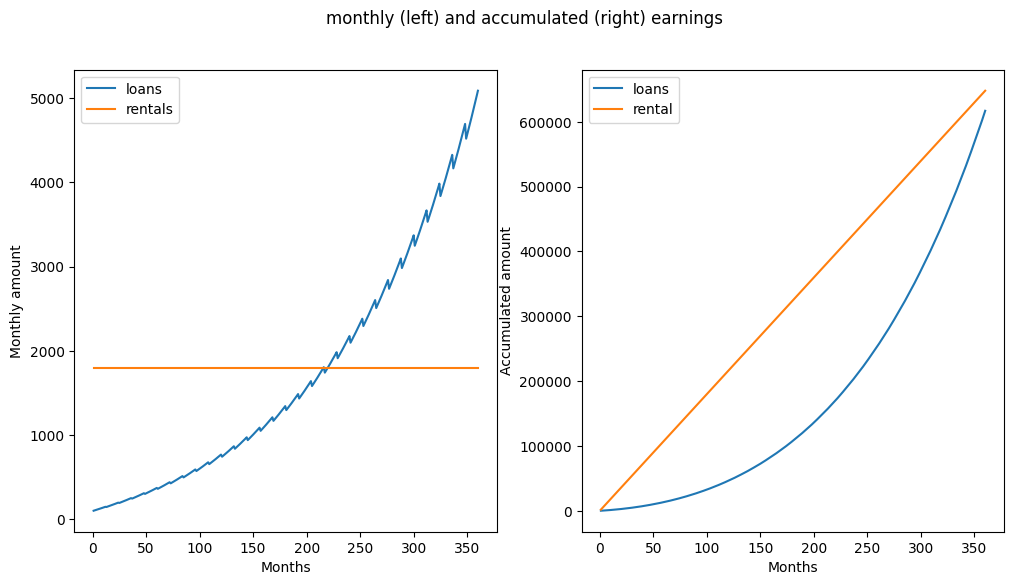

In [7]:
# common parameters
duration = 30
months = np.arange(12 * duration) + 1
rental_accum = 0
rental_month = 1800
retirement_at = 0
retirement_income = 1500
retirement_contribution = 50
rental_accum_income = []
rental_income_history = []

# Investment Parameters
principal_amount = 10_000
annual_contribution = 300 * 12  # 50 * 12
roi = 0.12
term_frequency = 1
periodic_contribution = annual_contribution / term_frequency
rental_accum = 0

inc_contribution = 0.01
inflation_rate = 0.02
tax_rate = 0.25
retirement_contribution_rate = 0.1

# Calculate cumulative rental income
for month in months:
    rental_accum += rental_month
    rental_income_history.append(rental_month)

#  Calculate ROI using the `calculate_return_on_investment` function
total_loan_balance, loan_earnings, balances = simulate_compound_return(
    principal=principal_amount,
    annual_roi=roi,
    compounding_frequency=term_frequency,
    annual_contribution=periodic_contribution,
    inc_contribution_rate=inc_contribution,
    investment_duration=duration,
    retirement_at=0,
    inflation_rate=inflation_rate,
    tax_rate=tax_rate,
    return_time_yields=True
)

# Stats
total_loan_earnings = sum(loan_earnings)
total_loan_contribution = total_loan_balance - total_loan_earnings
earning_per_contribution = total_loan_earnings / total_loan_contribution

# Months to equality
month_equal_earnings = np.abs(np.array(loan_earnings) - np.array(rental_income_history)).argmin()
month_equal_accum_earnings = np.abs(np.cumsum(loan_earnings) - np.cumsum(rental_income_history)).argmin()

print(f"Total contribution to loans {total_loan_contribution}")
print(f"Earnings through loan investment {total_loan_earnings}")
print(f"Earnings through house renting {sum(rental_income_history)}")
print(f"Loan earnings per contribution {earning_per_contribution}", end=2*"\n")

# ======================== #

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.plot(months, loan_earnings, label="loans")
plt.plot(months, rental_income_history, label="rentals")
plt.xlabel("Months")
plt.ylabel("Monthly amount")
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(months, np.cumsum(loan_earnings), label="loans")
plt.plot(months, np.cumsum(rental_income_history), label="rental")
plt.xlabel("Months")
plt.ylabel("Accumulated amount")
plt.legend()

_ = fig.suptitle("monthly (left) and accumulated (right) earnings")

print(f"Years to reach loan and rental earnings equality {month_equal_earnings // 12}")
print(f"Years to reach loan and rental accumulated earnings equality {month_equal_accum_earnings // 12}")

In [8]:
len(loan_earnings), len(balances)

(360, 360)

See how loan-investment-vehicle overcomes rental case after ~ 30 years.

## Simulation of scenarios to find equality of loan and rental earnings

In [11]:
scenarios = {}
# Time
durations = np.arange(10, 50 + 15, 5)
monthly_rental_incomes = np.arange(600, 2000 + 100, 100)
# Income
principal_amount = 10_000
monthly_rental_income = 1800
# Roi
rois = np.arange(0.04, 0.12 + 0.01, 0.01)
annual_contributions = 12 * np.arange(50, 300, 50)
inc_contributions = 0.01
terms = 1
warmup_months = 10
inflation_rate = 0.02
tax_rate = 0.25
retirement_contribution_rate = 0.1

for duration in durations:
    for monthly_rental_income in monthly_rental_incomes:
        rental_income = np.repeat(monthly_rental_income, 12 * duration)
        accumulated_rental_income = np.cumsum(rental_income)
        for roi in rois:
            for annual_contribution in annual_contributions:
                # Loan simulation
                _, earnings, balances = simulate_compound_return(
                    principal=principal_amount,
                    annual_roi=roi,
                    compounding_frequency=term_frequency,
                    annual_contribution=annual_contribution,
                    inc_contribution_rate=inc_contribution,
                    investment_duration=duration,
                    retirement_at=0,
                    inflation_rate=inflation_rate,
                    tax_rate=tax_rate,
                    return_time_yields=True
                )
                
                # Estimate months until loan and rental earnings are approximately equal
                years_to_equality = np.abs(np.cumsum(earnings) - accumulated_rental_income)[warmup_months:].argmin() / 12
                
                scenarios[(duration, monthly_rental_income, roi, annual_contribution)] = years_to_equality

In [12]:
multi_index = pd.MultiIndex.from_tuples(list(scenarios.keys()), names=["duration",
                                                                       "rental_income",
                                                                       "roi",
                                                                       "annual_contribution"])

df_years = pd.DataFrame(data=list(scenarios.values()),
                          index=multi_index,
                          columns=["years_to_equality"]
                         ) \
               .astype(int) \
               .replace(0, np.nan) \
               .dropna() \
               .sort_values("years_to_equality",
                            ascending=True
                           )
df_years

years_to_equality
duration rental_income roi  annual_contribution                   
55       600           0.12 3000                              15.0
20       600           0.12 3000                              15.0
45       600           0.12 3000                              15.0
35       600           0.12 3000                              15.0
50       600           0.12 3000                              15.0
...                                                            ...
60       1500          0.07 3000                              58.0
         700           0.06 1800                              59.0
         1500          0.09 1200                              59.0
         1000          0.07 1800                              59.0
         1800          0.08 2400                              59.0

[1524 rows x 1 columns]

In [17]:
df_years["equal_at_10_years"] = df_years["years_to_equality"].between(1, 10)
df_years["equal_at_15_years"] = df_years["years_to_equality"].between(1, 15)
df_years["equal_at_20_years"] = df_years["years_to_equality"].between(1, 20)
df_years["equal_at_30_years"] = df_years["years_to_equality"].between(1, 30)
df_years["equal_at_40_years"] = df_years["years_to_equality"].between(1, 40)
df_years

years_to_equality  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              15.0   
20       600           0.12 3000                              15.0   
45       600           0.12 3000                              15.0   
35       600           0.12 3000                              15.0   
50       600           0.12 3000                              15.0   
...                                                            ...   
60       1500          0.07 3000                              58.0   
         700           0.06 1800                              59.0   
         1500          0.09 1200                              59.0   
         1000          0.07 1800                              59.0   
         1800          0.08 2400                              59.0   

                                                 equal_at_10_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                             False   
20       600           0.12 3000                             False   
45       600           0.12 3000                             False   
35       600           0.12 3000                             False   
50       600           0.12 3000                             False   
...                                                            ...   
60       1500          0.07 3000                             False   
         700           0.06 1800                             False   
         1500          0.09 1200                             False   
         1000          0.07 1800                             False   
         1800          0.08 2400                             False   

                                                 equal_at_15_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                              True   
50       600           0.12 3000                              True   
...                                                            ...   
60       1500          0.07 3000                             False   
         700           0.06 1800                             False   
         1500          0.09 1200                             False   
         1000          0.07 1800                             False   
         1800          0.08 2400                             False   

                                                 equal_at_20_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                              True   
50       600           0.12 3000                              True   
...                                                            ...   
60       1500          0.07 3000                             False   
         700           0.06 1800                             False   
         1500          0.09 1200                             False   
         1000          0.07 1800                             False   
         1800          0.08 2400                             False   

                                                 equal_at_30_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                       

In [14]:
100 * df_years.mean(axis=0)

years_to_equality    3532.742782
equal_at_10_years       0.000000
equal_at_15_years       0.590551
equal_at_20_years       5.511811
equal_at_30_years      32.677165
equal_at_40_years      71.259843
dtype: float64

Takeaways:

+ From grid of parameters presented in this simulation, we found out there are few loan-investments which overcome the rental case in 15 years of investment duration.
+ It isn't until 20 years that some loan-vehicle-investments start to become more worthy than the rental case.

In [16]:
df_years.loc[df_years["equal_at_20_years"]]

years_to_equality  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              15.0   
20       600           0.12 3000                              15.0   
45       600           0.12 3000                              15.0   
35       600           0.12 3000                              15.0   
50       600           0.12 3000                              15.0   
...                                                            ...   
30       700           0.12 2400                              20.0   
         600           0.11 2400                              20.0   
25       700           0.12 2400                              20.0   
         600           0.10 3000                              20.0   
30       600           0.10 3000                              20.0   

                                                 equal_at_10_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                             False   
20       600           0.12 3000                             False   
45       600           0.12 3000                             False   
35       600           0.12 3000                             False   
50       600           0.12 3000                             False   
...                                                            ...   
30       700           0.12 2400                             False   
         600           0.11 2400                             False   
25       700           0.12 2400                             False   
         600           0.10 3000                             False   
30       600           0.10 3000                             False   

                                                 equal_at_15_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                              True   
50       600           0.12 3000                              True   
...                                                            ...   
30       700           0.12 2400                             False   
         600           0.11 2400                             False   
25       700           0.12 2400                             False   
         600           0.10 3000                             False   
30       600           0.10 3000                             False   

                                                 equal_at_20_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                              True   
50       600           0.12 3000                              True   
...                                                            ...   
30       700           0.12 2400                              True   
         600           0.11 2400                              True   
25       700           0.12 2400                              True   
         600           0.10 3000                              True   
30       600           0.10 3000                              True   

                                                 equal_at_30_years  \
duration rental_income roi  annual_contribution                      
55       600           0.12 3000                              True   
20       600           0.12 3000                              True   
45       600           0.12 3000                              True   
35       600           0.12 3000                       